<a href="https://colab.research.google.com/github/krenerd/PersonalProjects/blob/main/MultistageObjectDetection(PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# doesn't matter much :)
from google.colab import drive
drive.mount('/content/drive') #usg 45

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install efficientnet_pytorch   #for efficientnet backbone
!pip install torchmetrics
!pip install wandb

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 385, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/comm

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow # cv2.imshow for COLAB
#from cv2 import imshow as cv2_imshow # <--- use this for regular use.
import os
import re
import random
import time
import pickle

from skimage import io
import shutil
from tqdm import tqdm
import tarfile
import requests
import urllib.request
import xml.etree.ElementTree as ET
from PIL import Image
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchmetrics import Accuracy
from efficientnet_pytorch import EfficientNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Define HParams

In [2]:
config={'image_size':224, 'n_classes':21, 'bbox_reg': False, 'network': 'efficientnet-b0', 'max_proposals':2000}
train_config={'log_wandb':True, 'logging': ['map', 'plot'],
              'epochs': 5, 'batch_size':128, 'lr': 0.001, 'l2_reg': 1e-5, 'bbox_reg': False, 'bbox_iou_threshold':0.6}

voc_2012_classes=['background','Aeroplane',"Bicycle",'Bird',"Boat","Bottle","Bus","Car","Cat","Chair",'Cow',"Dining table","Dog","Horse","Motorbike",'Person', "Potted plant",'Sheep',"Sofa","Train","TV/monitor"]

# Load data

In [3]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

## Download data

In [4]:
class VOCDataset():
  def __init__(self):
    self.train_dir=None
    self.test_dir=None
    self.trainDataLink=None
    self.testDataLink=None

    self.common_init()

  def common_init(self):
    # init that must be shared among all subclasses of this method
    self.label_type=['none','aeroplane',"Bicycle",'bird',"Boat","Bottle","Bus","Car","Cat","Chair",'cow',"Diningtable","Dog","Horse","Motorbike",'person', "Pottedplant",'sheep',"Sofa","Train","TVmonitor"]
    self.convert_id=['background','Aeroplane',"Bicycle",'Bird',"Boat","Bottle","Bus","Car","Cat","Chair",'Cow',"Dining table","Dog","Horse","Motorbike",'Person', "Potted plant",'Sheep',"Sofa","Train","TV/monitor"]
    self.convert_labels={}
    for idx, x in enumerate(self.label_type):
      self.convert_labels[x.lower()]=idx

    self.num_classes=len(self.label_type) # 20 + 1(none)

  def download_dataset(self, validation_size=5000):
    # download voc train dataset
    print('[*] Downloading dataset...')
    print(self.trainDataLink)
    urllib.request.urlretrieve(self.trainDataLink, 'voctrain.tar')

    print('[*] Extracting dataset...')
    tar = tarfile.open('voctrain.tar', "r:")
    tar.extractall('/content/VOCtrain')
    tar.close()
    os.remove('/content/voctrain.tar')

    if self.testDataLink is None: 
      # move 5K images to validation set
      print('[*] Moving validation data...')
      ensure_dir(self.test_dir+'/Annotations/')
      ensure_dir(self.test_dir+'/JPEGImages/')

      random.seed(42)
      val_images = random.sample(sorted(os.listdir(self.train_dir + '/JPEGImages')), validation_size)

      for path in val_images:
        img_name = path.split('/')[-1].split('.')[0]
        # move image
        os.rename(self.train_dir+'/JPEGImages/'+img_name+'.jpg', self.test_dir+'/JPEGImages/'+img_name+'.jpg')
        # move annotation
        os.rename(self.train_dir+'/Annotations/'+img_name+'.xml', self.test_dir+'/Annotations/'+img_name+'.xml')
    else: 
      # Load from val data
      print('[*] Downloading validation dataset...')
      urllib.request.urlretrieve(self.testDataLink, 'voctest.tar')

      print('[*] Extracting validation dataset...')
      tar = tarfile.open('voctest.tar', "r:")
      tar.extractall('/content/VOCtest')
      tar.close()
      os.remove('/content/voctest.tar')

  def read_xml(self, xml_path): 
    object_list=[]

    tree = ET.parse(open(xml_path, 'r'))
    root=tree.getroot()
  
    objects = root.findall("object")
    for _object in objects:
      name = _object.find("name").text
      bndbox = _object.find("bndbox")
      xmin = int(bndbox.find("xmin").text)
      ymin = int(bndbox.find("ymin").text)
      xmax = int(bndbox.find("xmax").text)
      ymax = int(bndbox.find("ymax").text)
      class_name = _object.find('name').text
      object_list.append({'x1':xmin, 'x2':xmax, 'y1':ymin, 'y2':ymax, 'class': self.convert_labels[class_name]})

    return object_list

In [5]:
class VOC2007(VOCDataset):
  def __init__(self):
    self.train_dir='/content/VOCtrain/VOCdevkit/VOC2007'
    self.test_dir='/content/VOCtest/VOCdevkit/VOC2007'
    self.trainDataLink='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
    self.testDataLink='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar'
    self.common_init()#mandatory
    
class VOC2012(VOCDataset):
  def __init__(self):
    self.train_dir='/content/VOCtrain/VOCdevkit/VOC2012'
    self.test_dir='/content/VOCtest/VOCdevkit/VOC2012'
    # original site goes down frequently, so we use a link to the clone alternatively
    # self.trainDataLink='http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar' 
    self.trainDataLink = 'http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar'
    self.testDataLink=None
    self.common_init()#mandatory

In [8]:
voc_dataset=VOC2012()
voc_dataset.download_dataset()

In [9]:
val_datalen=len(os.listdir(voc_dataset.test_dir+'/Annotations'))
train_datalen=len(os.listdir(voc_dataset.train_dir+'/Annotations'))
print(train_datalen, val_datalen) # 17,125 total

12125 5000


## Demostrate

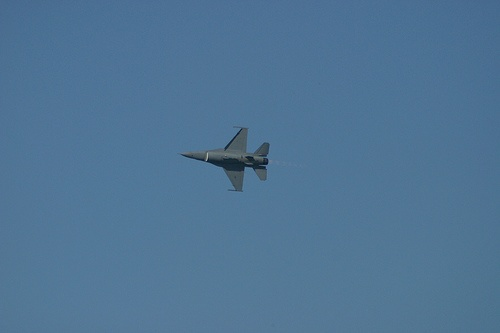

Shape: (333, 500, 3)


In [10]:
img_name = sorted(os.listdir(voc_dataset.train_dir+'/JPEGImages'))[10][:-4]

img=cv2.imread(voc_dataset.train_dir+'/JPEGImages/'+img_name+'.jpg')
cv2_imshow(img)
print('Shape:', img.shape)

w, h: 500 333


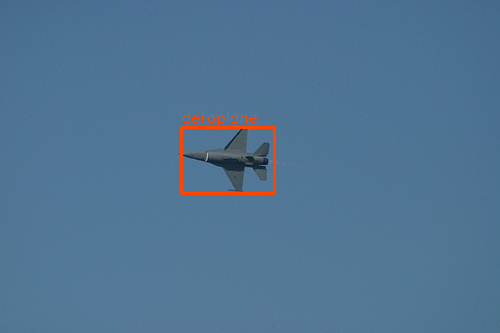

In [11]:
# referenced code of https://deepbaksuvision.github.io/Modu_ObjectDetection/posts/02_01_PASCAL_VOC.html
xml_path=voc_dataset.train_dir+'/Annotations/'+img_name+'.xml'
tree = ET.parse(open(xml_path, 'r'))

root=tree.getroot()
# print image shape
w, h = root.find("size").find("width").text, root.find("size").find("height").text
print('w, h:', w, h)

# plot bounding boxes
box_im=img.copy()
bbox_color=(0, 69, 255) # (b, g, r) not (r, g, b)
bbox_thickness=2

font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = 0.5
fontColor              = bbox_color
lineType               = 1


objects = root.findall("object")
for _object in objects:
  name = _object.find("name").text
  bndbox = _object.find("bndbox")
  xmin = int(bndbox.find("xmin").text)
  ymin = int(bndbox.find("ymin").text)
  xmax = int(bndbox.find("xmax").text)
  ymax = int(bndbox.find("ymax").text)
  class_name = _object.find('name').text

  cv2.rectangle(box_im, (xmin, ymin), (xmax, ymax), bbox_color, bbox_thickness)
  cv2.putText(box_im, class_name, (xmin, ymin-5), font, 
    fontScale,
    fontColor,
    lineType)

cv2_imshow(box_im)

### Demonstrate selective search


Found 89 boxes...


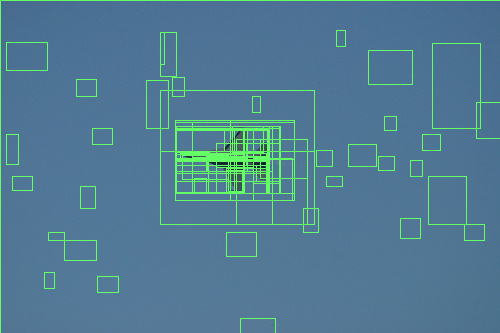

In [12]:
# referenced from https://github.com/Hulkido/RCNN/blob/master/RCNN.ipynb
img_ss=img.copy()

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img_ss)
ss.switchToSelectiveSearchFast() # "... extract around 2000 region proposals (we use selective search’s “fast mode” in all experiments)."
rects = ss.process()


print('Found',len(rects),'boxes...')
for i, rect in (enumerate(rects)):
  if i>2000:
    break
  x, y, w, h = rect
  cv2.rectangle(img_ss, (x, y), (x+w, y+h), (100, 255, 100), 1)
    
cv2_imshow(img_ss)

# Helper functions


In [13]:
def calculate_IoU(bb1, bb2):
  # calculate IoU(Intersection over Union) of 2 boxes 
  # **IoU = Area of Overlap / Area of Union
  # https://github.com/Hulkido/RCNN/blob/master/RCNN.ipynb

  x_left = max(bb1['x1'], bb2['x1'])
  y_top = max(bb1['y1'], bb2['y1'])
  x_right = min(bb1['x2'], bb2['x2'])
  y_bottom = min(bb1['y2'], bb2['y2'])
  # if there is no overlap output 0 as intersection area is zero.
  if x_right < x_left or y_bottom < y_top:
    return 0.0
  # calculate Overlapping area
  intersection_area = (x_right - x_left) * (y_bottom - y_top)
  bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
  bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
  union_area = bb1_area + bb2_area - intersection_area

  return intersection_area / union_area
  
def selective_search(image):
  # return region proposals of selective searh over an image
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(image)
  ss.switchToSelectiveSearchFast()
  return ss.process()

def plot_results(image, bboxes):
  plot_cfg = {'bbox_color':(0, 69, 255), 'bbox_thickness':2, 
                  'font':cv2.FONT_HERSHEY_SIMPLEX, 'fontScale':0.5, 'fontColor':(0, 69, 255), 'lineThickness':1}
  img_ss = img.copy()
  for box in bboxes:
    bbox = box['bbox']
    cv2.rectangle(img_ss, (bbox['x1'], bbox['y1']), (bbox['x2'], bbox['y2']), plot_cfg['bbox_color'], plot_cfg['bbox_thickness'])
    cv2.putText(img_ss, f"{voc_dataset.label_type[box['class']]}, {box['conf']}",  (bbox['x1'], bbox['y1'] - 5), plot_cfg['font'], 
                plot_cfg['fontScale'], plot_cfg['fontColor'], plot_cfg['lineThickness'])
  return img_ss

## Non-max suppression(NMS)


In [14]:
#https://learnopencv.com/non-maximum-suppression-theory-and-implementation-in-pytorch/
def nms(P, iou_threshold = 0.5):
  # P: list of dicts {'bbox':(x1,y1,x2,y2), 'conf':float, 'class':int}
  conf_list = np.array([x['conf'] for x in P])
  conf_order = (-conf_list).argsort() # apply minus to reverse order !!
  isremoved = [False for _ in range(len(P))]
  keep = []

  for idx in range(len(P)):
    to_keep = conf_order[idx]
    if isremoved[to_keep]:
      continue
    
    # append to keep list
    keep.append(P[to_keep])
    isremoved[to_keep] = True
    # remove overlapping bboxes
    for order in range(idx + 1, len(P)):
      bbox_idx = conf_order[order]
      if isremoved[bbox_idx]==False:  # if not removed yet
        # check overlapping
        iou = calculate_IoU(P[to_keep]['bbox'], P[bbox_idx]['bbox'])
        if iou > iou_threshold:
          isremoved[bbox_idx] = True
  return keep

# RCNN

## Data loaders

In [15]:
class RCNN_Dataset(torch.utils.data.Dataset):
  # https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
  def __init__(self, dataset, cfg, IoU_threshold={'positive':0.5, 'partial':0.3}, sample_ratio=(32, 96),
              data_path='/content/drive/MyDrive/data/rcnn_ss/'):
    """
    Args:
        label_file (list of tuple(im path, label)): Path to image + annotations.
        im_root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.data_path = data_path
    self.dataset = dataset
    self.transform = transforms.Compose([ # preprocess image
        transforms.Resize((cfg['image_size'], cfg['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    if self.dataset_exists()==False:
      self.generate_dataset(sample_ratio, IoU_threshold)
    else: 
      print('[*] Loading dataset from', self.data_path)
      with open(self.data_path + 'train_images.pkl', 'rb') as f:
        self.train_images=pickle.load(f)
      with open(self.data_path + 'train_labels.pkl', 'rb') as f:
        self.train_labels=pickle.load(f)

      # check if both files are complete, flawless
      if not len(self.train_images)==len(self.train_labels):
        raise ValueError('The loaded dataset is invalid (of different size).')

  def __len__(self):
    return len(self.train_labels)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()
    image=Image.fromarray(cv2.cvtColor(self.train_images[idx], cv2.COLOR_BGR2RGB))
    return  {'image': self.transform(image), 'label': self.train_labels[idx][0], 
             'est_bbox': self.train_labels[idx][1], 'gt_bbox': self.train_labels[idx][2]}
  '''
  # not working when interact too much w/ drive :(
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()

    img_name = os.path.join(self.im_root_dir, self.label_file[idx][0])
    image = io.imread(img_name)
    if self.transform:
        image = self.transform(image)
    return  {'image': image, 'label': self.label_file[idx][1]}
  '''
  def dataset_exists(self):
    if os.path.exists(self.data_path+'train_images.pkl')==False:
      return False
    if os.path.exists(self.data_path + 'train_labels.pkl')==False:
      return False
    
    return True    

  def generate_dataset(self, sample_ratio, IoU_threshold):
    #https://github.com/Hulkido/RCNN/blob/master/RCNN.ipynb

    image_dir=self.dataset.train_dir+'/JPEGImages/'
    annot_dir=self.dataset.train_dir+'/Annotations/'
    image_count = 0
    self.train_images=[]
    self.train_labels=[]

    print('[*] Generating dataset for R-CNN.')
    for img_name in tqdm(sorted(os.listdir(image_dir))[:1000], position=0, leave=True):   # only 1000 images :( <-------------
      obj_counter = 0
      bg_counter = 0
      # load image & gt bounding boxes 
      image = cv2.imread(image_dir + img_name)
      xml_path=annot_dir+img_name[:-4]+'.xml'
      gt_bboxes = self.dataset.read_xml(xml_path)
      # generete bbox proposals via selective search
      rects = selective_search(image)
      # loop through all ss bounding box proposals
      for (x, y, w, h) in rects[:2000]:

        bbox_est = {'x1':x, 'y1':y, 'x2':x+w, 'y2':y+h}
        # check the proposal with every elements of the gt boxes
        for gt_bbox in gt_bboxes:
          iou = calculate_IoU(gt_bbox, bbox_est)

          if obj_counter < sample_ratio[0] and iou >= IoU_threshold['positive']: # if object(RoI > 0.5)
            obj_counter+=1
            cropped = image[y:y+h, x:x+w, :]
            self.train_images.append(cropped)
            #cv2.imwrite(self.data_path+'train_images/'+str(image_count)+'.jpg', cropped) <-- too much drive I/O, timed out
            #image_count+=1
            gt_bbox_xywh=((gt_bbox['x1'] + gt_bbox['x2']) / 2, (gt_bbox['y1'] + gt_bbox['y2']) / 2,
                           gt_bbox['x2']-gt_bbox['x1'], gt_bbox['y2']-gt_bbox['y1'])
            self.train_labels.append([gt_bbox['class'], (x, y, w, h), gt_bbox_xywh])
            
          if bg_counter < sample_ratio[1] and iou < IoU_threshold['positive']: # if background
            bg_counter+=1
            cropped = image[y:y+h, x:x+w, :]
            self.train_images.append(cropped)
            #cv2.imwrite(self.data_path+'train_images/'+str(image_count)+'.jpg', cropped) <-- too much drive I/O, timed out
            #image_count+=1
            gt_bbox_xywh=((gt_bbox['x1'] + gt_bbox['x2']) / 2, (gt_bbox['y1'] + gt_bbox['y2']) / 2,
                           gt_bbox['x2']-gt_bbox['x1'], gt_bbox['y2']-gt_bbox['y1'])
            self.train_labels.append([0, (x, y, w, h), gt_bbox_xywh])

          if obj_counter==sample_ratio[0] and bg_counter==sample_ratio[1]:  # control the ratio between 2 types
            break
    print('[*] Dataset generated! Saving labels to', self.data_path)
    with open(self.data_path + 'train_labels.pkl', 'wb') as f:
      pickle.dump(self.train_labels, f)
    with open(self.data_path + 'train_images.pkl', 'wb') as f:
      pickle.dump(self.train_images, f)

In [16]:
def RCNN_DatasetLoader(voc_dataset, cfg, training_cfg, shuffle=True):
  ds = RCNN_Dataset(voc_dataset, cfg)
  return torch.utils.data.DataLoader(ds, batch_size=training_cfg['batch_size'], shuffle=shuffle, num_workers=2)

In [17]:
loader=RCNN_DatasetLoader(voc_dataset, config, train_config)    # `loader` is an instance of RCNN_dataset

[*] Loading dataset from /content/drive/MyDrive/data/rcnn_ss/


tensor([ 0,  0,  0,  0,  0,  0,  9,  0,  0,  0, 13,  0, 15,  0,  0,  0,  0,  3,
         0,  0,  0,  0,  0,  0,  0,  0, 15,  0,  0,  0,  0,  0,  0,  0,  0,  9,
         0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  7,  0,  0,  0,  0,  0, 15,
         0,  0,  0,  3,  6,  0,  0,  5,  0,  0,  1,  0,  0,  0,  0,  0,  7,  0,
         0,  0,  0, 15,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 15, 10,  0,  0,  0, 15,  0,  0, 15, 16,  0,  0,  0,  4, 15,  0,  0,
         0,  0, 15,  0, 15,  0,  0, 15,  0,  0,  0,  0,  0,  0, 12,  0,  0, 18,
         1,  0])
tensor(29)


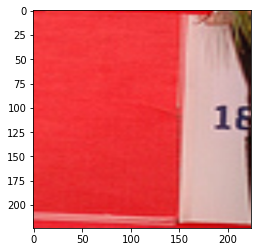

background


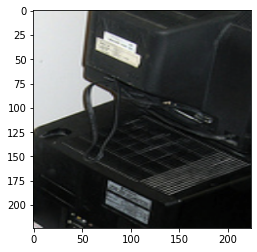

background


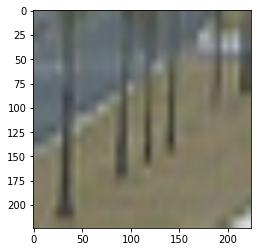

background


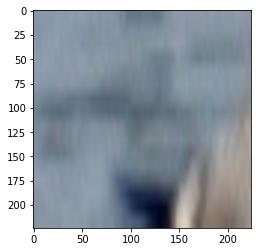

background


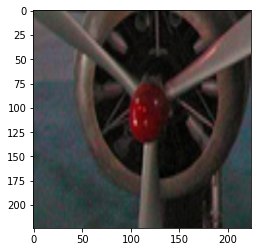

background


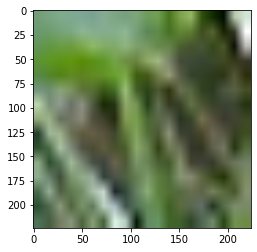

background


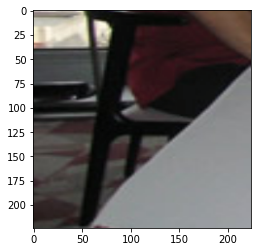

Chair


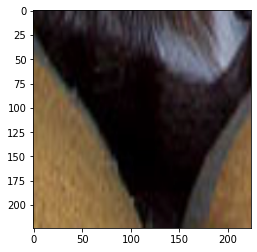

background


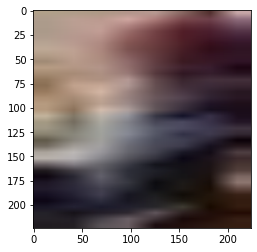

background


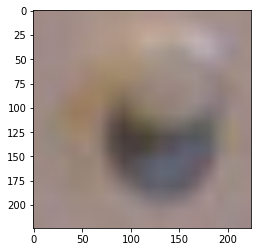

background


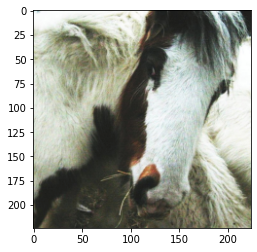

Horse


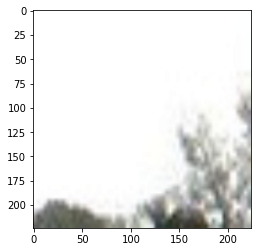

background


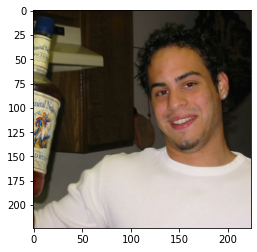

Person


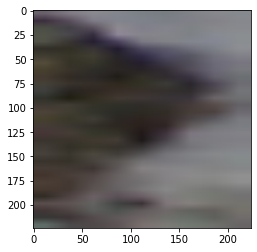

background


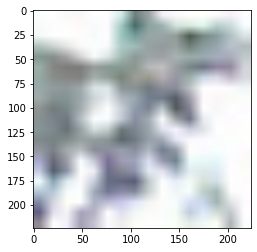

background


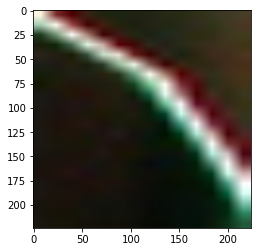

background


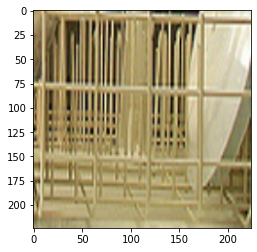

background


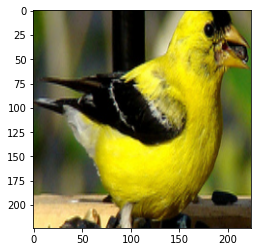

Bird


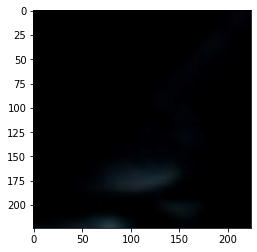

background


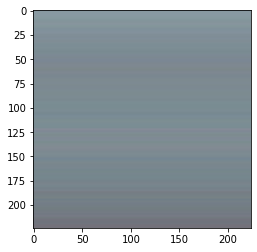

background


In [18]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],std = [ 1., 1., 1. ]), 
                                transforms.ToPILImage() ])

for x in loader:
  print(x['label'])
  print(sum(x['label']>0))
  for idx in range(20):
    plt.imshow(invTrans(x['image'][idx]))
    plt.show()
    print(voc_2012_classes[x['label'][idx]])
  break

## Network Architecture

In [33]:
def RCNN(cfg, load_path=None):
  if load_path:
    print('[*] Attempting to load model from:', load_path)
    loaded = torch.load(load_path)
    # check whether `loaded` is an RCNN instance
    if loaded.__class__.__name__ == '_RCNN':
      return loaded
    else:
      raise ValueError('The loaded tensor is not an instance of _RCNN.')
  else:
    print('[*] Creating model...')
    return _RCNN(cfg)

class ExtractFeatures(nn.Module):
  def __init__(self, effnet):
    super(ExtractFeatures, self).__init__()
    self.avgpool2d=nn.AvgPool2d(7)
    self.flatten=nn.Flatten()

  def forward(self, x):
    x=self.avgpool2d(x)
    return self.flatten(x)
    
class _RCNN(nn.Module):
  def __init__(self, cfg):
    super(_RCNN, self).__init__()
    self.num_classes = cfg['n_classes'] 
    self.dobbox_reg = cfg['bbox_reg']
    self.max_proposals = cfg['max_proposals'] # maximum number of regions to extract from given image at inference
    self.image_size = cfg['image_size'] # efficientnet-b0: 224

    if cfg['network']=='efficientnet-b0':
      self.initialize_weights()

  def inference(self, image, rgb=False, batch_size = 128, apply_nms=True): # image must be loaded in BGR format(cv2.imread) or else rgb must be set to True
    # https://www.pyimagesearch.com/2020/07/13/r-cnn-object-detection-with-keras-tensorflow-and-deep-learning/
    self.eval()

    if rgb==True: # convert rgb to bgr
      image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    preprocess = transforms.Compose([ # preprocess image
      transforms.ToPILImage(),
      transforms.Resize((self.image_size, self.image_size)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # perferm selective search to find region proposals
    rects=selective_search(image)

    proposals=[]
    boxes=[]
    
    for (x, y, w, h) in rects[:self.max_proposals]:
      roi = cv2.cvtColor(image[y:y+h,x:x+w, :], cv2.COLOR_BGR2RGB)
      roi = preprocess(roi)

      proposals.append(roi)
      boxes.append({'x1':x, 'y1':y, 'x2':x + w, 'y2':y + h})

    # convert to DataLoader for batching
    proposals = torch.stack(proposals)
    proposals = torch.Tensor(proposals)
    proposals = torch.utils.data.TensorDataset(proposals)
    proposals = torch.utils.data.DataLoader(proposals, batch_size=batch_size)

    # predict probability of each box
    cnt = 0
    useful_bboxes = []
    for proposal_batch in tqdm(proposals, position= 0):
      patches = proposal_batch[0].to(device)
      with torch.no_grad():
        features = self.convnet(patches)
        features = self.flatten(features)
        pred = self.classifier(features)

      useful_idx = torch.where(pred.argmax(1)>0)  # patches which are not bg
      for idx in useful_idx[0]:
        estimate = pred[idx].cpu().detach().numpy()
        useful_bboxes.append({'class': estimate.argmax(0), 'conf': estimate.max(0), 'bbox': boxes[cnt * batch_size + idx.cpu().detach().numpy()]})
      cnt += 1

    # apply non-max suppression to remove duplicate boxes
    if apply_nms: 
      useful_bboxes = nms(useful_bboxes, 0.5)

    return useful_bboxes

  def inference_batch(self, images):
    pass

  def initialize_weights(self):
      print('[*] Initializing new network...')
      self.effnet = EfficientNet.from_pretrained('efficientnet-b0', num_classes=21).to(device)

      self.convnet = self.effnet.extract_features
      self.flatten = nn.Sequential(nn.AvgPool2d(7), nn.Flatten()).to(device)
      
      self.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=False), nn.Linear(1280, 21)).to(device)

      if self.dobbox_reg:
        self.bbox_reg = nn.Sequential(nn.Dropout(p=0.2, inplace=False), nn.Linear(1280, 4)).to(device)


## Training Loop

In [35]:
class RCNN_Trainer():
  def __init__(self, model, loader, validator=None):
    self.model=model
    self.loader=loader  
    self.validator=validator

  def fine_tuning(self, train_cfg):
    if train_cfg['log_wandb']:
      wandb.init(project='rcnn', entity='krenerd77')
      wandb.watch(self.model, log_freq=100)

    x, y, w, h = 0, 1, 2, 3 # for conversion to idx

    cce = nn.CrossEntropyLoss()
    mse = nn.MSELoss()

    optimizer = optim.SGD(self.model.parameters(), lr = train_cfg['lr'], momentum=0.9, weight_decay=train_cfg['l2_reg'])
    self.validator=None
    if self.validator is not None: 
      self.validator.initialize(self.model, train_cfg['logging'])

    self.model.train()  # set model to train mode
    for epoch in range(train_cfg['epochs']): 
      print('[*] Training epoch',epoch + 1, '/',train_cfg['epochs'])
      pbar = tqdm(loader, position=0, leave=True)
      for step, data in enumerate(pbar):
        optimizer.zero_grad()
        # implement training step -------------------------
        # inference
        features = self.model.convnet(data['image'].to(device))
        features = self.model.flatten(features)
        output = self.model.classifier(features)
          
        # backprop
        loss = cce(output, data['label'].to(device))
        
        # bbox regression loss
        if train_cfg['bbox_reg']==True:
          bbox_est = self.model.bbox_reg(features)
          # regression targets are described in Appendix C. 
          bbox_ans = ((data['est_bbox'][x] - data['gt_bbox'][x]) / data['est_bbox'][w], 
                      (data['est_bbox'][y] - data['gt_bbox'][y]) / data['est_bbox'][h], 
                      torch.log(data['gt_bbox'][w] / data['est_bbox'][w]), 
                      torch.log(data['gt_bbox'][h] / data['est_bbox'][h]))
          # add to loss
          bbox_loss = mse(bbox_est, bbox_ans)
          loss += bbox_loss
          
        loss.backward()
        optimizer.step()
        # logging ------------------------------------------
        pbar.set_description(f"Loss: {loss.cpu().detach().numpy()}")
        if train_cfg['log_wandb'] and (step) % 100==0:
          wandb.log({'clf_loss': loss})

      # save checkpoints and log
      torch.save(self.model, 'RCNN_checkpoint.pt')
      if self.validator is not None: 
        self.validator.validate() 


# Validation

In [36]:
class ValDataset(torch.utils.data.Dataset):
  # https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
  def __init__(self, dataset):
    self.base_dir = dataset.test_dir
    self.dataset = dataset
    self.images = sorted(os.listdir(dataset.test_dir+'/JPEGImages/'))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()

    image_path = self.base_dir + '/JPEGImages/' + self.images[idx]
    image = cv2.imread(image_path)

    annot_dir = self.base_dir + '/Annotations/' +self.images[idx][:-4]+'.xml'
    gt_bboxes = self.dataset.read_xml(xml_path) # load bboxes in list of dicts {x1, x2, y1, y2, class}
    return  {'image': image, 'label': gt_bboxes}

In [37]:
val_dataset = ValDataset(voc_dataset)

In [38]:
class PlotSamples():
  def __init__(self, to_sample=10):
    # create table for plotting 
    self.to_sample = to_sample
    sample_columns = ['sample '+str(x+1) for x in range(to_sample)]
    self.sample_table = wandb.Table(columns=sample_columns)

  def log(self, model, val_dataset):
    print('[*] Plotting samples to wandb board...')
    sampled = []
    for x in range(self.to_sample):
      img=val_dataset[x]['image']
      bboxes=model.inference(img)

      result_image = plot_results(img, bboxes)
      sampled.append(wandb.Image(result_image))
    # write to table
    self.sample_table.add_data(*sampled)
    wandb.run.log({"Samples_table" : self.sample_table})

class ComputeMAP():
  def __init__(self, iou_threshold=0.5):
    # create table for plotting 
    self.iou_threshold = iou_threshold
    self.sample_table = wandb.Table(columns=voc_2012_classes)

  def log(self, model, val_dataset):
    return 0
    val_images = sorted(os.listdir(image_path))
    
    sampled = []
    for x in range(to_sample):
      img=cv2.imread(image_path+val_images[x]+'.jpg')
      bboxes=model.inference(img)

      result_image = plot_results(img, bboxes)
      sampled.append(result_image)
    return sampled

In [39]:
class Validator():
  def __init__(self, val_dataset):
    self.val_dataset = val_dataset

  def initialize(self, model, log_keys): 
    self.model = model 

    self.loggers = {}
    self.log_keys = log_keys
    log_funcs = {'map': ComputeMAP, 'plot': PlotSamples}
    for logtype in log_keys: 
      self.loggers[logtype] = log_funcs[logtype]()

  def validate(self):
    for key in self.log_keys:
      self.loggers[key].log(model, self.val_dataset)

# Train & Evaluate Network

In [40]:
config={'image_size':224, 'n_classes':21, 'bbox_reg': False, 'network': 'efficientnet-b0', 'max_proposals':2000}
train_config={'log_wandb':True, 'logging': ['map', 'plot'],
              'epochs': 5, 'batch_size':128, 'lr': 0.001, 'l2_reg': 1e-5, 'bbox_reg': False, 'bbox_iou_threshold':0.6}

voc_2012_classes=['background','Aeroplane',"Bicycle",'Bird',"Boat","Bottle","Bus","Car","Cat","Chair",'Cow',"Dining table","Dog","Horse","Motorbike",'Person', "Potted plant",'Sheep',"Sofa","Train","TV/monitor"]

In [41]:
model=RCNN(config, load_path = None).to(device)
validator=Validator(val_dataset)
trainer=RCNN_Trainer(model, loader, validator)

[*] Creating model...
[*] Initializing new network...
Loaded pretrained weights for efficientnet-b0


In [ ]:
trainer.fine_tuning(train_config)

clf_loss,█▂▂▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁
clf_loss,0.54583


[*] Training epoch 1 / 5


Loss: 0.6180627346038818:  74%|███████▍  | 701/946 [06:50<02:31,  1.61it/s]

In [ ]:
from google.colab import files
files.download('RCNN_checkpoint.pt') 

In [28]:
for idx in range(10):
  img_name = sorted(os.listdir(voc_dataset.train_dir+'/JPEGImages'))[idx][:-4]

  img=cv2.imread(voc_dataset.train_dir+'/JPEGImages/'+img_name+'.jpg')
  print('Shape:', img.shape)
  bboxes=model.inference(img)
  res=plot_results(img, bboxes)
  plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
  plt.show()

Shape: (500, 486, 3)


AttributeError: ignored

In [ ]:
bboxes=model.inference(img)

In [ ]:
res=plot_results(img, bboxes)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
bboxes_nms = nms(bboxes, 0.2)
plot_results(img, bboxes_nms)

In [ ]:
# referenced from https://github.com/Hulkido/RCNN/blob/master/RCNN.ipynb
img_ss=img.copy()

for x in ds:

  x1, y1, x2, y2 = x['bbox']
  cv2.rectangle(img_ss, (x1, y1), (x2, y2), (100, 255, 100), 1)
  cv2.putText(img_ss, f"{voc_dataset.label_type[x['class']]}+{x['conf']}",  (x1, y1-5), font, 
    fontScale,
    fontColor,
    lineType)
cv2_imshow(img_ss)

In [ ]:
ds

In [ ]:
for proposal_batch in tqdm(proposals_dataset, position= 0):
      print(proposal_batch[0])
      features = model.convnet(proposal_batch[0])
      pred = model.classifier(features)
      print(pred.argmax(0))
      input()

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

In [ ]:
trainer.fine_tuning(train_config)

In [ ]:
from google.colab import files
files.download('RCNN_checkpoint.pt')


In [ ]:
img.shape

In [ ]:
t = transforms.Compose([ # preprocess image
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
t(img).shape

In [ ]:
torch.Tensor([[1,2], [2,3], [4, 5]])